Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [12]:
NAME = "Jiahao Liu"
COLLABORATORS = "None"

---

# Problem description

In the last assignment, we created fully connected neural networks to
solve the task of classifying whether a ship is present in a satellite photo.

This assignment will address the same task, but using Convolutional Neural Network layers.


## Goal:

In this notebook, you will need to create a model in `TensorFlow/Keras` *using Convolutional layers*  to classify satellite photos.

- The features are images: 3 dimensional collection of pixels
  - 2 spatial dimensions
  - 1 dimension with 3 features for different parts of the color spectrum: Red, Green, Blue
- The labels are either 1 (ship is present) or 0 (ship is not present)

Unlike the model we created in the previous assignment (using Dense/Fully Connected layers)
we will retain *all three color channels* of the data rather than converting it to one channel gray scale.

There are two notebook files in this assignment:
- The one you are viewing now: First and only notebook you need to work on.
    - Train your models here
    - There are cells that will save your models to a file
- **`Model_test.ipynb`**:
    - PLEASE IGNORE    


## Learning objectives
- Learn how to construct Neural Networks in a Keras Sequential model that uses Convolutional layer types.
- Appreciate how layer choices impact number of weights

# Import modules

In [13]:
## Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn

import os
import math

%matplotlib inline

## Import tensorflow
import tensorflow as tf
from tensorflow.keras.utils import plot_model

print("Running TensorFlow version ",tf.__version__)

# Parse tensorflow version
import re

version_match = re.match("([0-9]+)\.([0-9]+)", tf.__version__)
tf_major, tf_minor = int(version_match.group(1)) , int(version_match.group(2))
print("Version {v:d}, minor {m:d}".format(v=tf_major, m=tf_minor) )

Running TensorFlow version  2.15.0
Version 2, minor 15


# API for students

We have defined some utility routines in a file `helper.py`. There is a class named `Helper` in it.  

This will simplify problem solving

More importantly: it adds structure to your submission so that it may be easily graded

`helper = helper.Helper()`

- getData: Get a collection of labeled images, used as follows

  >`data, labels = helper.getData()`
- showData: Visualize labelled images, used as follows

  >`helper.showData(data, labels)`
- plot training results: Visualize training accuracy, loss and validation accuracy, loss

  >`helper.plotTrain(history, modelName)`, where history is the result of model training
- save model: save a model in `./models` directory

  >`helper.saveModel(model, modelName)`
- save history: save a model history in `./models` directory
  >`helper.saveHistory(history, modelName)`



In [20]:
# Load the helper module
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%reload_ext autoreload
%autoreload 1

# Import nn_helper module
!pip install nose
import helper
%aimport helper

## You may pass an optional `data_dir` argument to the constructor `helper.Helper`
- if you have your data directory located somewhere other than the default location
- no need to provide an argument otherwise

For example:

        helper = helper.Helper(data_dir="./MyDataDir")

In [21]:
helper = helper.Helper()

# Get the data

The first step in our Recipe is Get the Data.

We have provided a utility method `getData` to simplify this for you

In [22]:
# Get the data
data, labels = helper.getData()
n_samples, width, height, channel = data.shape

print("Data shape: ", data.shape)
print("Labels shape: ", labels.shape)
print("Label values: ", np.unique(labels))



Data shape:  (4000, 80, 80, 3)
Labels shape:  (4000,)
Label values:  [0 1]


We will shuffle the examples before doing anything else.

This is usually a good idea
- Many datasets are naturally arranged in a *non-random* order, e.g., examples with the sample label grouped together
- You want to make sure that, when you split the examples into training and test examples, each split has a similar distribution of examples

In [23]:
# Shuffle the data
data, labels = sklearn.utils.shuffle(data, labels, random_state=42)

## Have a look at the data

We will not go through all steps in the Recipe, nor in depth.

But here's a peek


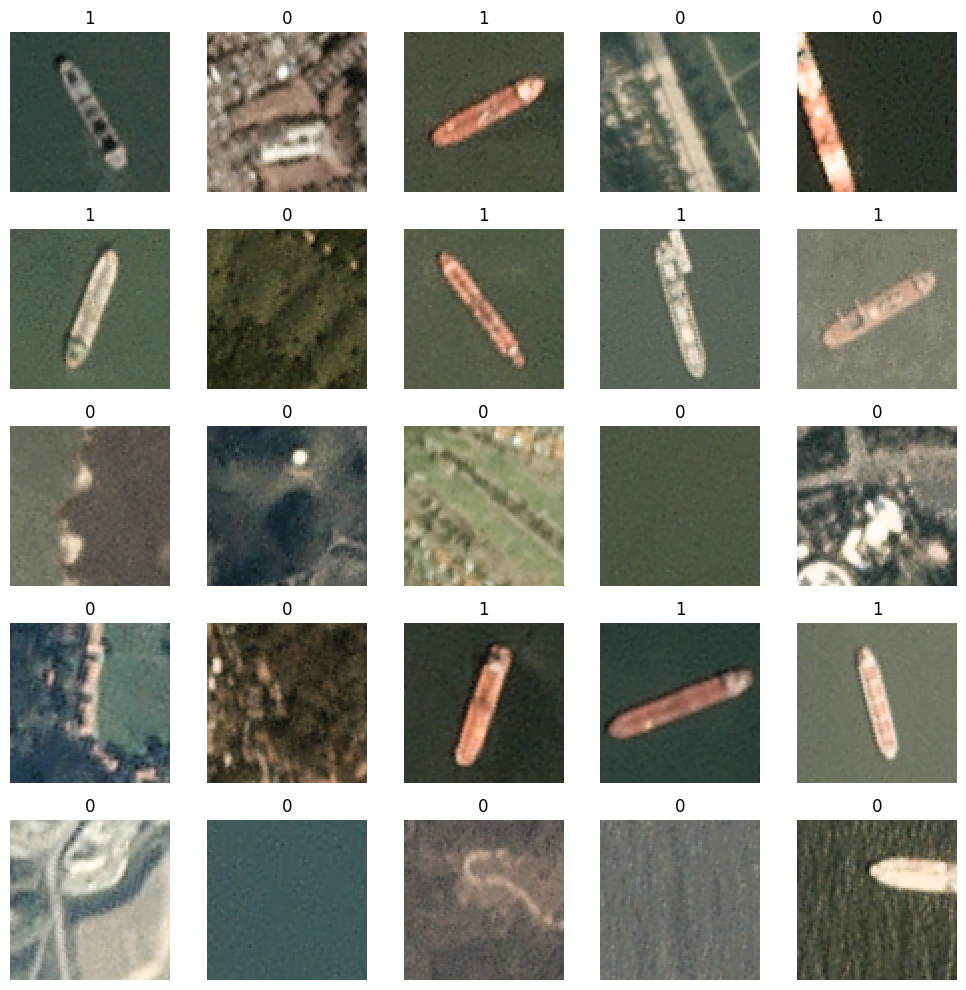

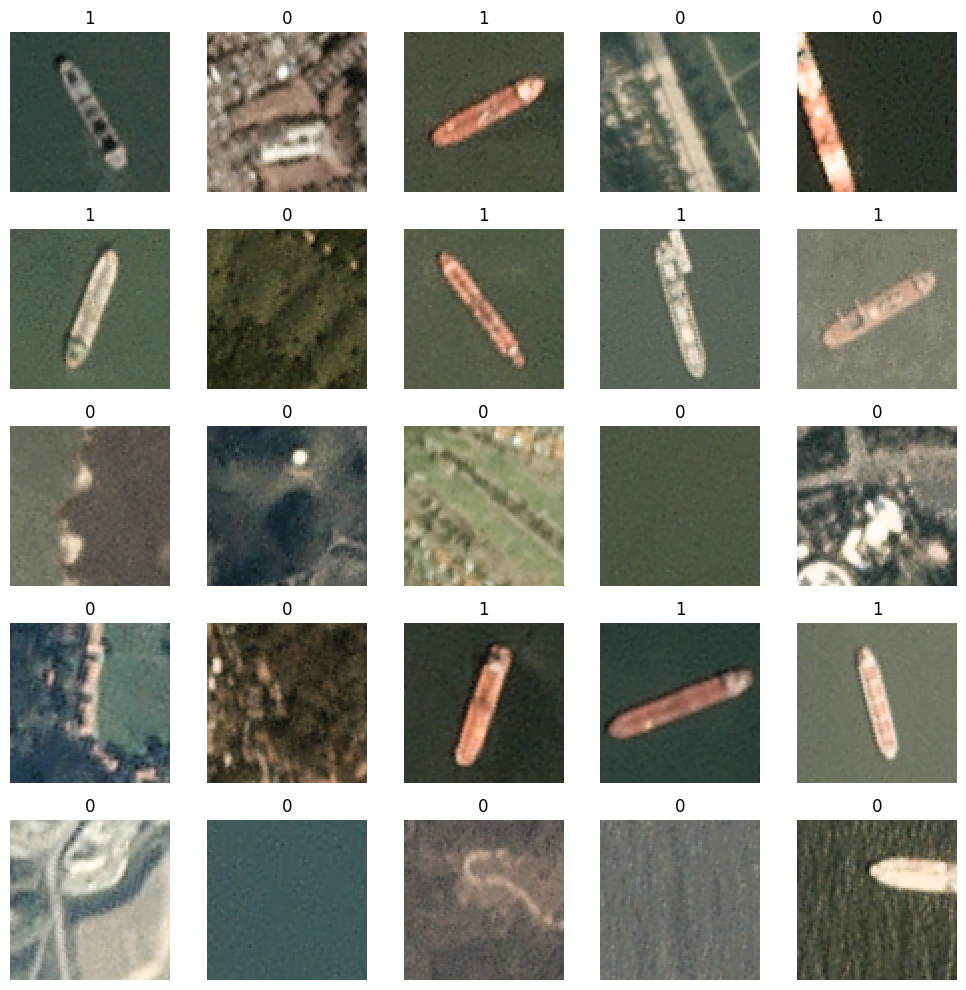

In [24]:
# Visualize the data samples
helper.showData(data[:25], labels[:25])


## Have  look at the data: Examine the image/label pairs

Rather than viewing the examples in random order, let's group them by label.

Perhaps we will learn something about the characteristics of images that contain ships.

We have loaded and shuffled our dataset, now we will take a look at image/label pairs.

Feel free to explore the data using your own ideas and techniques.


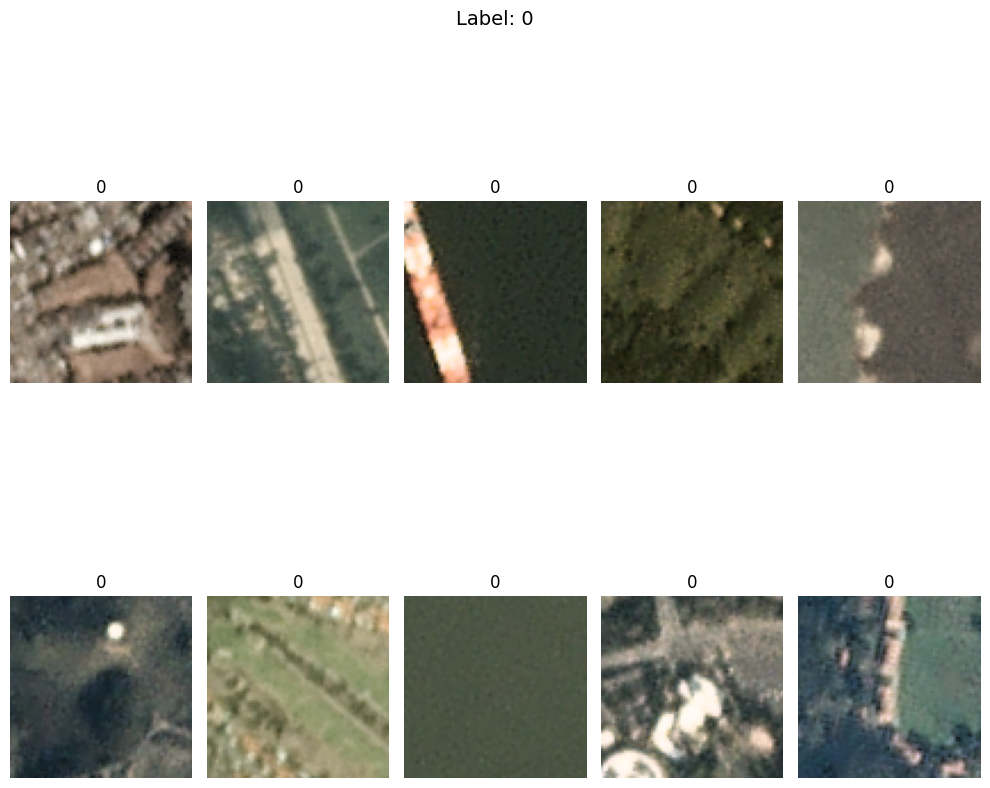

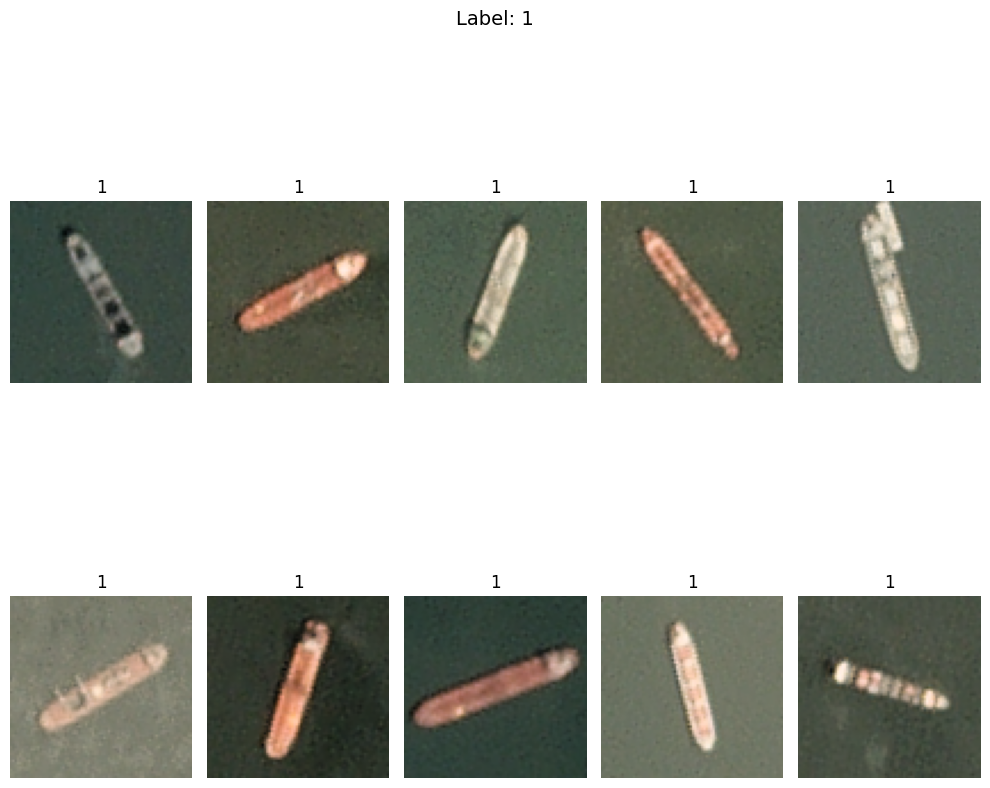

In [25]:
# Inspect some data (images)
num_each_label = 10

for lab in np.unique(labels):
    # Fetch images with different labels
    X_lab, y_lab = data[ labels == lab ], labels[ labels == lab]
    # Display images
    fig = helper.showData( X_lab[:num_each_label], [ str(label) for label in y_lab[:num_each_label] ], cmap="gray")
    _ = fig.suptitle("Label: "+  str(lab), fontsize=14)
    print("\n\n")


# Make sure the features are in the range [0,1]  

**Warm up exercise:** When we want to train on image data, the first thing we usually need to do is scaling.

Since the feature values in our image data are between 0 and 255, to make them between 0 and 1, we need to divide them by 255.  

We also need to consider how to represent our target values
- If there are more than 2 possible target values, One Hot Encoding may be appropriate
    - **Hint**: Lookup `tf.keras.utils.to_categorical`
- If there are only 2 possible targets with values 0 and 1 we can use these targets without further encoding

**Question**
- Set variable `X` to be our **color** (3 channels) examples (`data`), but with values in the range [0,1]
- Set variable `y` to be the representation of our target values



In [26]:
# Scale the data
# Assign values for X, y
#  X: the array of features
#  y: the array of labels
# The length of X and y should be identical and equal to the length of data.
from tensorflow.keras.utils import to_categorical
X, y = np.array([]), np.array([])

# YOUR CODE HERE
X = data/255
y = labels
#raise NotImplementedError()

In [27]:
# Check if your solution is right

assert X.shape == (4000, 80, 80, 3)
assert ( (y.shape == (4000,)) or (y.shape == (4000,1)) )


# Split data into training data and testing data
To train and evaluate a model, we need to split the original dataset into
a training subset (in-sample) and a test subset (out of sample).

We will do this for you in the cell below.

**DO NOT** shuffle the data until after we have performed the split into train/test sets
- We want everyone to have the **identical** test set for grading
- Do not change this cell



In [28]:
# Split data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

# Save X_train, X_test, y_train, y_test for final testing
if not os.path.exists('./data'):
    os.mkdir('./data')
np.savez_compressed('./data/train_test_data.npz', X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)


# Create a simple CNN model

**Question:** Create a Keras Sequential model:
- With a single Convolutional Layer providing the number of features given in variable `num_conv_features1` indicated below.
    - You may choose your own kernel size
    - Use same padding
- Feeding a head layer implementing Classification  

Please name your Convolutional layer "CNN_1" and your Dense layer (head layer) "dense_head"

Set variable `model0` to be a Keras `Sequential` model object that implements your model.

**Hints:**
1. The `input shape` argument of the first layer should be the shape of a single example, which should be 3-dimensional. We don't need to flatten the data before feeding the Convolutional layer.
2. What is the shape of the output of the Convolutional Layer ? What should be the shape of the input to the Classification head ?
    - You may want to flatten the output of the Convolutional layer before feeding the Classification head.
3. The number of units in your head layer
    - Depends on how you represented the target
    - It should be equal to the final dimension of  `y`

4. Activation function for the head layer: Since this is a classification problem
    - Use  `sigmoid` if your target's final dimension equals 1
    - Use  `softmax` if your target's final dimension is greater than 1

Think about the number of parameters in this model and whether
it is likely to be prone to overfitting.
If you feel the need:

- A Dropout layer maybe helpful to prevent overfitting and accelerate your training process.
    - If you want to use a Dropout layer, you can use `Dropout()`, which is in  `tensorflow.keras.layers`.



In [29]:
print(X_train[0].shape)

(80, 80, 3)


In [30]:
# Set model0 equal to a Keras Sequential model
model0 = None

num_conv_features1 = 32

# YOUR CODE HERE
#raise NotImplementedError()
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
model0 = Sequential([Conv2D(num_conv_features1,kernel_size=(3,3),activation='relu',input_shape=X_train[0].shape,padding='same',name='CNN_1'),
            Dropout(0.5),
            Flatten(),
            Dense(1, activation='sigmoid',name='dense_head')])

model0.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 CNN_1 (Conv2D)              (None, 80, 80, 32)        896       
                                                                 
 dropout (Dropout)           (None, 80, 80, 32)        0         
                                                                 
 flatten (Flatten)           (None, 204800)            0         
                                                                 
 dense_head (Dense)          (None, 1)                 204801    
                                                                 
Total params: 205697 (803.50 KB)
Trainable params: 205697 (803.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


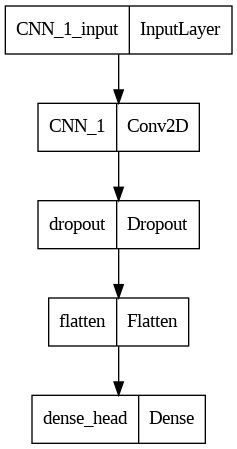

In [31]:
# Plot your model
plot_model(model0)

## Train model


**Question:**

Now that you have built your first model, you will compile and train it. The requirements are as follows:

- Split the **training** examples `X_train, y_train` again !
    - 80% will be used for training the model
    - 20% will be used as validation (out of sample) examples
    - Use `train_test_split()` from `sklearn` to perform this split
        -  Set the `random_state` parameter of `train_test_split()` to be 42

- Loss function:
    - `binary_crossentropy` if your target is one-dimensional
    - `categorical_crossentropy`if your target is One Hot Encoded
- Metric: "accuracy"
- Use the value in variable `max_epochs` as the number of epochs for training

- Plot your training results using the`plotTrain` method described in the Student API above.


Epoch 1/10
90/90 [==============================] - 3s 15ms/step - loss: 0.0888 - accuracy: 0.9694 - val_loss: 0.1190 - val_accuracy: 0.9542
Epoch 2/10
90/90 [==============================] - 1s 9ms/step - loss: 0.0698 - accuracy: 0.9781 - val_loss: 0.0955 - val_accuracy: 0.9653
Epoch 3/10
90/90 [==============================] - 1s 8ms/step - loss: 0.0576 - accuracy: 0.9823 - val_loss: 0.1255 - val_accuracy: 0.9472
Epoch 4/10
90/90 [==============================] - 1s 9ms/step - loss: 0.0572 - accuracy: 0.9854 - val_loss: 0.1218 - val_accuracy: 0.9486
Epoch 5/10
90/90 [==============================] - 1s 9ms/step - loss: 0.0462 - accuracy: 0.9861 - val_loss: 0.1073 - val_accuracy: 0.9597
Epoch 6/10
90/90 [==============================] - 1s 9ms/step - loss: 0.0469 - accuracy: 0.9844 - val_loss: 0.0981 - val_accuracy: 0.9569
Epoch 7/10
90/90 [==============================] - 1s 9ms/step - loss: 0.0421 - accuracy: 0.9872 - val_loss: 0.1102 - val_accuracy: 0.9569
Epoch 8/10
90/90 [=

(<Figure size 1200x500 with 2 Axes>,
 array([<Axes: title={'center': 'CNN + Head model loss'}, xlabel='epoch', ylabel='loss'>,
        <Axes: title={'center': 'CNN + Head model accuracy'}, xlabel='epoch', ylabel='accuracy'>],
       dtype=object))

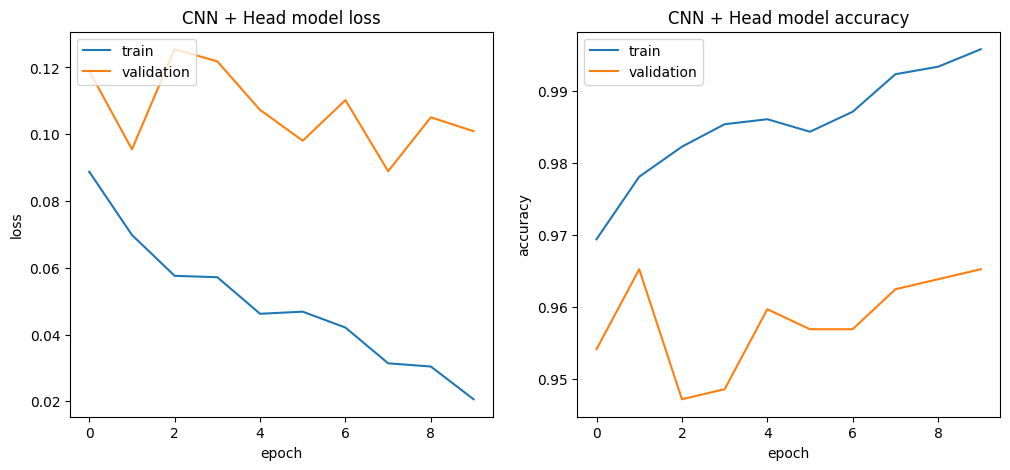

In [34]:
model_name0 = "CNN + Head"
max_epochs = 10

# YOUR CODE HERE
#raise NotImplementedError()
model0.compile(optimizer='adam',loss='binary_crossentropy',metrics='accuracy')
X_train_new,X_valid,y_train_new,y_valid = train_test_split(X_train,y_train,test_size=0.2,random_state=42)
history0 = model0.fit(X_train_new,y_train_new,epochs= max_epochs,validation_data=(X_valid,y_valid))
helper.plotTrain(history0,model_name0)

## How many weights in the model ?

**Question:**

Calculate the number of parameters in your model.  

Set variable `num_parameters0` to be equal to the number of parameters in your model.

**Hint:** The model object may have a method to help you ! Remember that Jupyter can help you find the methods that an object implements.



In [35]:
# Set num_parameters2 equal to the number of weights in the model
num_parameters0 = None

# YOUR CODE HERE
#raise NotImplementedError()
num_parameters0 = model0.count_params()
print("Parameters number in model0: ", num_parameters0)

Parameters number in model0:  205697


## Evaluate the model

**Question:**

We have trained our model. We now need to  evaluate the model using the test dataset created in an earlier cell.

Please store the model score in a variable named `score0`.   

**Hint:** The model object has a method  `evaluate`.  Use that to compute the score.




In [37]:
score0 = []

# YOUR CODE HERE
#raise NotImplementedError()
score0 = model0.evaluate(X_test,y_test)
print("{n:s}: Test loss: {l:3.2f} / Test accuracy: {a:3.2f}".format(n=model_name0, l=score0[0], a=score0[1]))

13/13 [==============================] - 0s 10ms/step - loss: 0.1283 - accuracy: 0.9550
CNN + Head: Test loss: 0.13 / Test accuracy: 0.95


Your test accuracy should be around 0.9

## Save the trained model0 and history for submission

Your fitted model can be saved for later use
- In general: so you can resume training at a later time
- In particular: to allow us to grade it !

Execute the following cell to save your model, which you will submit to us for grading.

In [39]:
helper.saveModel(model0, model_name0)
helper.saveHistory(history0, model_name0)

Model saved in ./models/CNN + Head.keras; submit with your assignment.


In [40]:
## Restore the model (make sure that it works)
model_loaded = helper.loadModel(model_name0)
score_loaded = model_loaded.evaluate(X_test, y_test, verbose=0)

assert score_loaded[0] == score0[0] and score_loaded[1] == score0[1]

# Create a model with 4 Convolutional layers

**Question:**

We will now create a model with more Convolutional layers.
- Use **4** Convolutional layers.
    - You may choose your own kernel size
    - Use full padding
    - ReLU activation functions for the Convolutional layers

    - Each of the first two Convolutional layers should have the number of features given in variable `num_conv_features1` indicated below
        - Please name thee layers "CNN_1" and "CNN_2"
    - Each of the last two Convolutional layers should have the number of features given in variable `num_conv_features2` indicated below
        - Please name thee layers "CNN_3" and "CNN_4"
- Insert a `MaxPooling` layer after every two Convolutional layers (e.g., after CNN_2 and CNN_4)
    - to reduce each spatial dimension by a factor of 2  

- Please name your head layer "dense_head".

Set variable `model1` to be a Keras `Sequential` model object that implements your model.

**Hints:**
- Don't forget to flatten the output of the layer feeding the Classification head
- A Dropout layer maybe helpful to prevent overfitting and accelerate your training process.


In [53]:
# Set model1 equal to a Keras Sequential model
model1 = None
num_conv_features1 = 32
num_conv_features2 = 64

# YOUR CODE HERE
#raise NotImplementedError()
numf = [32,32,64,64]
model1 = Sequential([Conv2D(numf[0],kernel_size=(3,3),padding='valid',activation='relu',input_shape=X_train[0].shape,name='CNN_1'),
            Conv2D(numf[1],kernel_size=(3,3),padding='valid',activation='relu',name='CNN_2'),
            MaxPooling2D(pool_size=(2,2)),
            Conv2D(numf[2],kernel_size=(3,3),padding='valid',activation='relu',name='CNN_3'),
            Conv2D(numf[3],kernel_size=(3,3),padding='valid',activation='relu',name='CNN_4'),
            MaxPooling2D(pool_size=(2,2)),
            Dropout(0.5),
            Flatten(),
            Dense(1,activation='sigmoid',name='dense_head')])
model1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 CNN_1 (Conv2D)              (None, 78, 78, 32)        896       
                                                                 
 CNN_2 (Conv2D)              (None, 76, 76, 32)        9248      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 38, 38, 32)        0         
 g2D)                                                            
                                                                 
 CNN_3 (Conv2D)              (None, 36, 36, 64)        18496     
                                                                 
 CNN_4 (Conv2D)              (None, 34, 34, 64)        36928     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 17, 17, 64)        0         
 g2D)                                                 

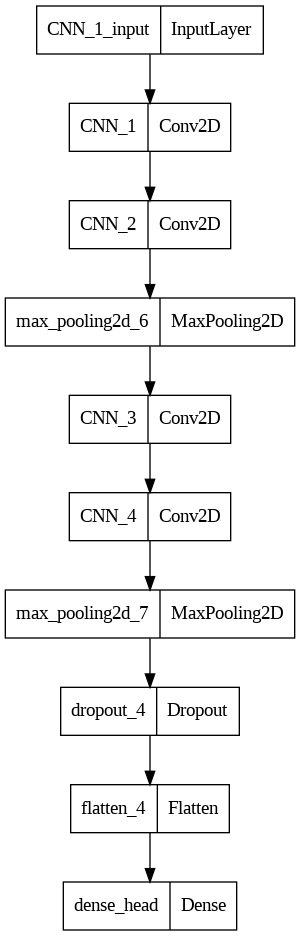

In [54]:
# Plot your model
plot_model(model1)

## Train model

**Question:**

Train your new model following the same instructions as given for training the first model.
- Use the same datasets for training and validation as in your first model
- Use the same Loss function and metrics as in your first model
- **Except**: Save your training results in a variable named `history1`



Epoch 1/10
90/90 [==============================] - 5s 28ms/step - loss: 0.3871 - accuracy: 0.8434 - val_loss: 0.1623 - val_accuracy: 0.9306
Epoch 2/10
90/90 [==============================] - 2s 20ms/step - loss: 0.2365 - accuracy: 0.9094 - val_loss: 0.1420 - val_accuracy: 0.9389
Epoch 3/10
90/90 [==============================] - 2s 19ms/step - loss: 0.1805 - accuracy: 0.9285 - val_loss: 0.1379 - val_accuracy: 0.9444
Epoch 4/10
90/90 [==============================] - 2s 19ms/step - loss: 0.1667 - accuracy: 0.9385 - val_loss: 0.1476 - val_accuracy: 0.9472
Epoch 5/10
90/90 [==============================] - 2s 17ms/step - loss: 0.1385 - accuracy: 0.9472 - val_loss: 0.1146 - val_accuracy: 0.9542
Epoch 6/10
90/90 [==============================] - 2s 18ms/step - loss: 0.1124 - accuracy: 0.9583 - val_loss: 0.0810 - val_accuracy: 0.9750
Epoch 7/10
90/90 [==============================] - 2s 19ms/step - loss: 0.1008 - accuracy: 0.9635 - val_loss: 0.1132 - val_accuracy: 0.9514
Epoch 8/10
90

(<Figure size 1200x500 with 2 Axes>,
 array([<Axes: title={'center': '4CNNs + Head model loss'}, xlabel='epoch', ylabel='loss'>,
        <Axes: title={'center': '4CNNs + Head model accuracy'}, xlabel='epoch', ylabel='accuracy'>],
       dtype=object))

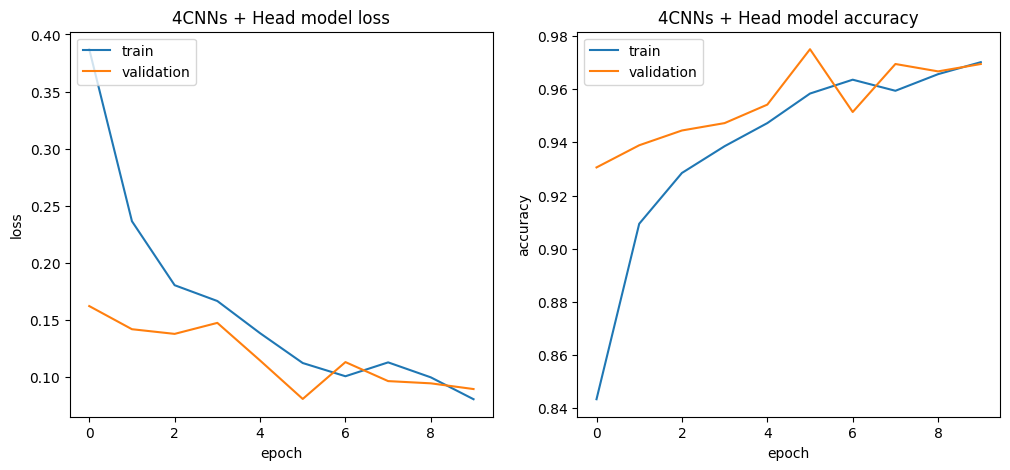

In [55]:
# Train the model using the API
model_name1 = "4CNNs + Head"

# YOUR CODE HERE
#raise NotImplementedError()
model1.compile(optimizer='adam',loss='binary_crossentropy',metrics='accuracy')
history1 = model1.fit(X_train_new,y_train_new,epochs= max_epochs,validation_data=(X_valid,y_valid))
helper.plotTrain(history1,model_name1)

## How many weights in this model ?

**Question:** Calculate the number of parameters in your new model.  

Set variable `num_parameters1` to be equal to the number of parameters in your model.



In [56]:
# Set num_parameters3 equal to the number of weights in the model
num_parameters1 = None

# YOUR CODE HERE
#raise NotImplementedError()
num_parameters1 = model1.count_params()
print('Parameters number in model1:', num_parameters1)

Parameters number in model1: 84065


## Evaluate the model

Evaluate your new model following the same instructions as given for evaluating the first model.
- **Except**: store the model score in a variable named `score1`.  



In [58]:
score1 = []

# YOUR CODE HERE
#raise NotImplementedError()
score1 = model1.evaluate(X_test,y_test)
print("{n:s}: Test loss: {l:3.2f} / Test accuracy: {a:3.2f}".format(n=model_name1, l=score1[0], a=score1[1]))

13/13 [==============================] - 0s 7ms/step - loss: 0.0772 - accuracy: 0.9675
4CNNs + Head: Test loss: 0.08 / Test accuracy: 0.97


Is your test accuracy higher than before ?

# Save your trained model1 and history1

In [59]:
helper.saveModel(model1, model_name1)
helper.saveHistory(history1, model_name1)

Model saved in ./models/4CNNs + Head.keras; submit with your assignment.


## Discussion


You can learn a lot by experimenting.  Some ideas to try:
- Change the kernel size in Convolutional layers
- Change the number of features of Convolutional layers
- Experiment with different pooling layers: `MaxPooling2D` and `AveragePooling2D`
- Change the activation function

Observe the effect of each change on the Loss and Accuracy.

Questions to consider:
- How did the number of parameters change between the two models ?
- How did the choice of layer types affect the number of parameters ?


# model2: change the kernel size

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 CNN_1 (Conv2D)              (None, 77, 77, 32)        1568      
                                                                 
 CNN_2 (Conv2D)              (None, 74, 74, 32)        16416     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 37, 37, 32)        0         
 g2D)                                                            
                                                                 
 CNN_3 (Conv2D)              (None, 34, 34, 64)        32832     
                                                                 
 CNN_4 (Conv2D)              (None, 31, 31, 64)        65600     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 15, 15, 64)        0         
 g2D)                                                 

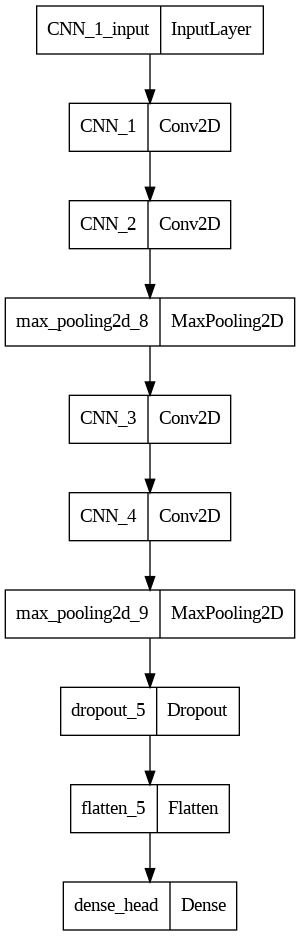

Epoch 1/10
90/90 [==============================] - 7s 34ms/step - loss: 0.4088 - accuracy: 0.8330 - val_loss: 0.2055 - val_accuracy: 0.9236
Epoch 2/10
90/90 [==============================] - 2s 22ms/step - loss: 0.2483 - accuracy: 0.9014 - val_loss: 0.1768 - val_accuracy: 0.9278
Epoch 3/10
90/90 [==============================] - 2s 24ms/step - loss: 0.2169 - accuracy: 0.9125 - val_loss: 0.1593 - val_accuracy: 0.9444
Epoch 4/10
90/90 [==============================] - 3s 29ms/step - loss: 0.1920 - accuracy: 0.9240 - val_loss: 0.1338 - val_accuracy: 0.9500
Epoch 5/10
90/90 [==============================] - 2s 25ms/step - loss: 0.1710 - accuracy: 0.9347 - val_loss: 0.1382 - val_accuracy: 0.9472
Epoch 6/10
90/90 [==============================] - 2s 24ms/step - loss: 0.1496 - accuracy: 0.9462 - val_loss: 0.2337 - val_accuracy: 0.8833
Epoch 7/10
90/90 [==============================] - 2s 21ms/step - loss: 0.1551 - accuracy: 0.9451 - val_loss: 0.1222 - val_accuracy: 0.9514
Epoch 8/10
90

(<Figure size 1200x500 with 2 Axes>,
 array([<Axes: title={'center': 'kernel_size(4,4) model loss'}, xlabel='epoch', ylabel='loss'>,
        <Axes: title={'center': 'kernel_size(4,4) model accuracy'}, xlabel='epoch', ylabel='accuracy'>],
       dtype=object))

Parameters number in model2: 130817
13/13 [==============================] - 0s 6ms/step - loss: 0.0764 - accuracy: 0.9775
kernel_size(4,4): Test loss: 0.08 / Test accuracy: 0.98
Model saved in ./models/kernel_size(4,4).keras; submit with your assignment.


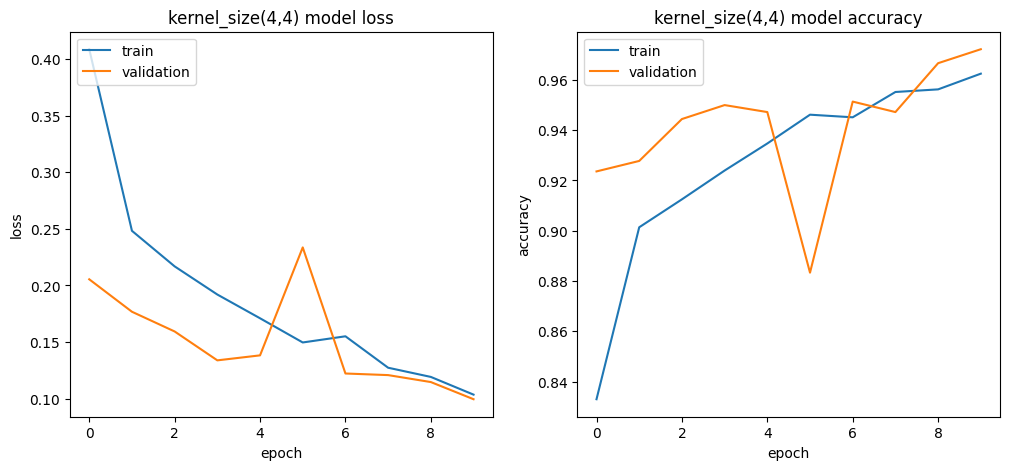

In [61]:
# Set model2
model2 = None
num_conv_features1 = 32
num_conv_features2 = 64
numf = [32,32,64,64]
model2 = Sequential([Conv2D(numf[0],kernel_size=(4,4),padding='valid',activation='relu',input_shape=X_train[0].shape,name='CNN_1'),
            Conv2D(numf[1],kernel_size=(4,4),padding='valid',activation='relu',name='CNN_2'),
            MaxPooling2D(pool_size=(2,2)),
            Conv2D(numf[2],kernel_size=(4,4),padding='valid',activation='relu',name='CNN_3'),
            Conv2D(numf[3],kernel_size=(4,4),padding='valid',activation='relu',name='CNN_4'),
            MaxPooling2D(pool_size=(2,2)),
            Dropout(0.5),
            Flatten(),
            Dense(1,activation='sigmoid',name='dense_head')])
model2.summary()
# Plot my model
plot_model(model2)
# Train the model
model_name2 = "kernel_size(4,4)"
model2.compile(optimizer='adam',loss='binary_crossentropy',metrics='accuracy')
history2 = model2.fit(X_train_new,y_train_new,epochs= max_epochs,validation_data=(X_valid,y_valid))
helper.plotTrain(history2,model_name2)

# the size of weight
num_parameters2 = model2.count_params()
print('Parameters number in model2:', num_parameters2)

# the score of this model
score2 = model2.evaluate(X_test,y_test)
print("{n:s}: Test loss: {l:3.2f} / Test accuracy: {a:3.2f}".format(n=model_name2, l=score2[0], a=score2[1]))

# save my model and history
helper.saveModel(model2, model_name2)
helper.saveHistory(history2, model_name2)

# model3: change the number of features of convolution layers

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 CNN_1 (Conv2D)              (None, 77, 77, 64)        3136      
                                                                 
 CNN_2 (Conv2D)              (None, 74, 74, 64)        65600     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 37, 37, 64)        0         
 ng2D)                                                           
                                                                 
 CNN_3 (Conv2D)              (None, 34, 34, 128)       131200    
                                                                 
 CNN_4 (Conv2D)              (None, 31, 31, 128)       262272    
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 15, 15, 128)       0         
 ng2D)                                                

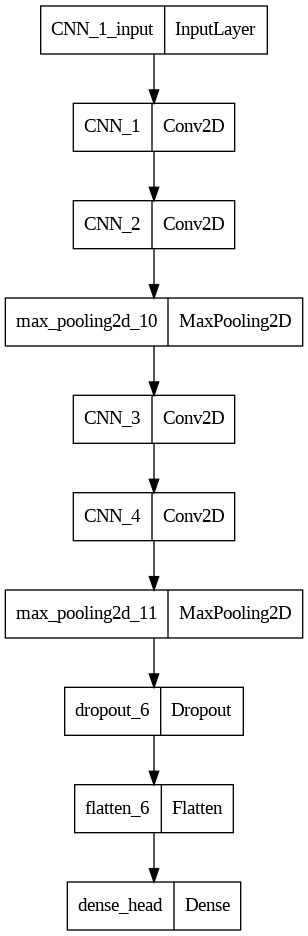

Epoch 1/10
90/90 [==============================] - 10s 58ms/step - loss: 0.3522 - accuracy: 0.8538 - val_loss: 0.2208 - val_accuracy: 0.9069
Epoch 2/10
90/90 [==============================] - 4s 49ms/step - loss: 0.2494 - accuracy: 0.9021 - val_loss: 0.1924 - val_accuracy: 0.9208
Epoch 3/10
90/90 [==============================] - 4s 49ms/step - loss: 0.2378 - accuracy: 0.9128 - val_loss: 0.2107 - val_accuracy: 0.9042
Epoch 4/10
90/90 [==============================] - 4s 48ms/step - loss: 0.2075 - accuracy: 0.9253 - val_loss: 0.1492 - val_accuracy: 0.9417
Epoch 5/10
90/90 [==============================] - 4s 47ms/step - loss: 0.1934 - accuracy: 0.9222 - val_loss: 0.1597 - val_accuracy: 0.9528
Epoch 6/10
90/90 [==============================] - 4s 48ms/step - loss: 0.1673 - accuracy: 0.9382 - val_loss: 0.1404 - val_accuracy: 0.9403
Epoch 7/10
90/90 [==============================] - 4s 49ms/step - loss: 0.1479 - accuracy: 0.9462 - val_loss: 0.1380 - val_accuracy: 0.9653
Epoch 8/10
9

(<Figure size 1200x500 with 2 Axes>,
 array([<Axes: title={'center': 'convolution feature(64,128) model loss'}, xlabel='epoch', ylabel='loss'>,
        <Axes: title={'center': 'convolution feature(64,128) model accuracy'}, xlabel='epoch', ylabel='accuracy'>],
       dtype=object))

Parameters number in model3: 491009
13/13 [==============================] - 0s 20ms/step - loss: 0.0858 - accuracy: 0.9700
kernel_size(4,4): Test loss: 0.09 / Test accuracy: 0.97
Model saved in ./models/convolution feature(64,128).keras; submit with your assignment.


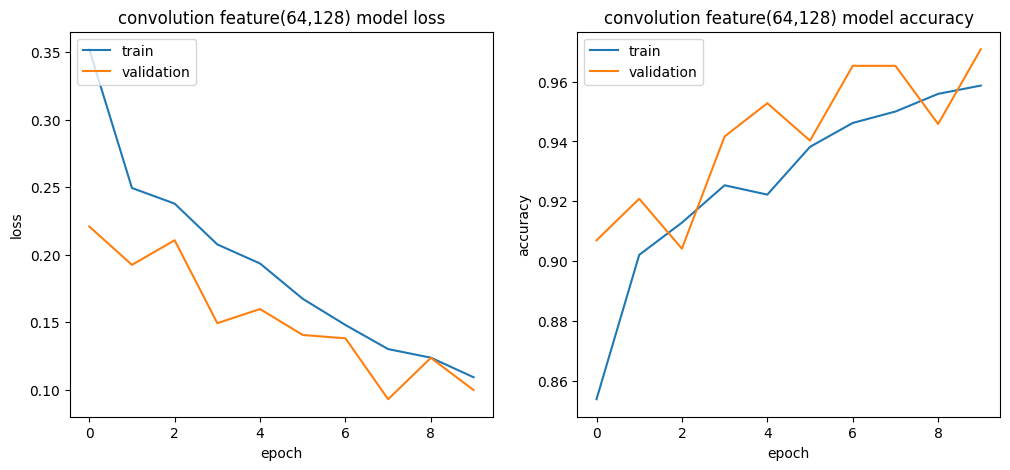

In [62]:
# Set model3
model3 = None
num_conv_features1 = 32
num_conv_features2 = 64
numf = [64,64,128,128]
model3 = Sequential([Conv2D(numf[0],kernel_size=(4,4),padding='valid',activation='relu',input_shape=X_train[0].shape,name='CNN_1'),
            Conv2D(numf[1],kernel_size=(4,4),padding='valid',activation='relu',name='CNN_2'),
            MaxPooling2D(pool_size=(2,2)),
            Conv2D(numf[2],kernel_size=(4,4),padding='valid',activation='relu',name='CNN_3'),
            Conv2D(numf[3],kernel_size=(4,4),padding='valid',activation='relu',name='CNN_4'),
            MaxPooling2D(pool_size=(2,2)),
            Dropout(0.5),
            Flatten(),
            Dense(1,activation='sigmoid',name='dense_head')])
model3.summary()
# Plot my model
plot_model(model3)
# Train the model
model_name3 = "convolution feature(64,128)"
model3.compile(optimizer='adam',loss='binary_crossentropy',metrics='accuracy')
history3 = model3.fit(X_train_new,y_train_new,epochs= max_epochs,validation_data=(X_valid,y_valid))
helper.plotTrain(history3,model_name3)

# the size of weight
num_parameters3 = model3.count_params()
print('Parameters number in model3:', num_parameters3)

# the score of this model
score3 = model3.evaluate(X_test,y_test)
print("{n:s}: Test loss: {l:3.2f} / Test accuracy: {a:3.2f}".format(n=model_name2, l=score3[0], a=score3[1]))

# save my model and history
helper.saveModel(model3, model_name3)
helper.saveHistory(history3, model_name3)

# model4: change the activation function of convolution layer into sigmoid

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 CNN_1 (Conv2D)              (None, 78, 78, 32)        896       
                                                                 
 CNN_2 (Conv2D)              (None, 76, 76, 32)        9248      
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 38, 38, 32)        0         
 ng2D)                                                           
                                                                 
 CNN_3 (Conv2D)              (None, 36, 36, 64)        18496     
                                                                 
 CNN_4 (Conv2D)              (None, 34, 34, 64)        36928     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 17, 17, 64)        0         
 ng2D)                                                

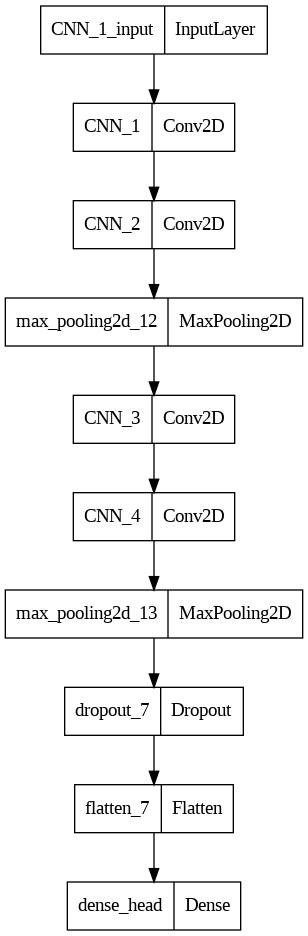

Epoch 1/10
90/90 [==============================] - 5s 29ms/step - loss: 0.7516 - accuracy: 0.7365 - val_loss: 0.5764 - val_accuracy: 0.7472
Epoch 2/10
90/90 [==============================] - 2s 21ms/step - loss: 0.5741 - accuracy: 0.7462 - val_loss: 0.5658 - val_accuracy: 0.7472
Epoch 3/10
90/90 [==============================] - 2s 22ms/step - loss: 0.5750 - accuracy: 0.7462 - val_loss: 0.5735 - val_accuracy: 0.7472
Epoch 4/10
90/90 [==============================] - 2s 22ms/step - loss: 0.5704 - accuracy: 0.7462 - val_loss: 0.5700 - val_accuracy: 0.7472
Epoch 5/10
90/90 [==============================] - 2s 22ms/step - loss: 0.5719 - accuracy: 0.7462 - val_loss: 0.5668 - val_accuracy: 0.7472
Epoch 6/10
90/90 [==============================] - 2s 22ms/step - loss: 0.5709 - accuracy: 0.7462 - val_loss: 0.5653 - val_accuracy: 0.7472
Epoch 7/10
90/90 [==============================] - 2s 23ms/step - loss: 0.5677 - accuracy: 0.7462 - val_loss: 0.5683 - val_accuracy: 0.7472
Epoch 8/10
90

(<Figure size 1200x500 with 2 Axes>,
 array([<Axes: title={'center': 'sigmoid model model loss'}, xlabel='epoch', ylabel='loss'>,
        <Axes: title={'center': 'sigmoid model model accuracy'}, xlabel='epoch', ylabel='accuracy'>],
       dtype=object))

Parameters number in model4: 84065
13/13 [==============================] - 0s 9ms/step - loss: 0.3409 - accuracy: 0.8525
sigmoid model: Test loss: 0.34 / Test accuracy: 0.85
Model saved in ./models/sigmoid model.keras; submit with your assignment.


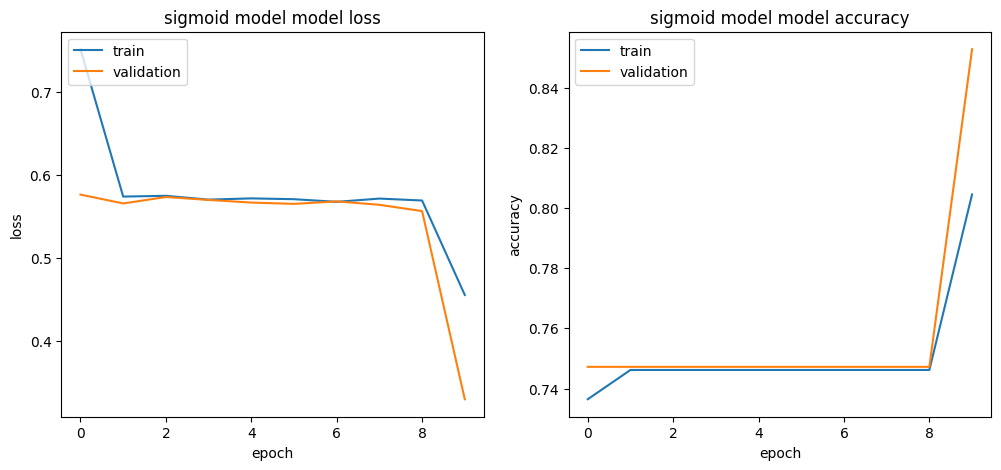

In [63]:
# Set model4
model4 = None
num_conv_features1 = 32
num_conv_features2 = 64
numf = [32,32,64,64]
model4 = Sequential([Conv2D(numf[0],kernel_size=(3,3),padding='valid',activation='sigmoid',input_shape=X_train[0].shape,name='CNN_1'),
            Conv2D(numf[1],kernel_size=(3,3),padding='valid',activation='sigmoid',name='CNN_2'),
            MaxPooling2D(pool_size=(2,2)),
            Conv2D(numf[2],kernel_size=(3,3),padding='valid',activation='sigmoid',name='CNN_3'),
            Conv2D(numf[3],kernel_size=(3,3),padding='valid',activation='sigmoid',name='CNN_4'),
            MaxPooling2D(pool_size=(2,2)),
            Dropout(0.5),
            Flatten(),
            Dense(1,activation='sigmoid',name='dense_head')])
model4.summary()
# Plot my model
plot_model(model4)
# Train the model
model_name4 = "sigmoid model"
model4.compile(optimizer='adam',loss='binary_crossentropy',metrics='accuracy')
history4 = model4.fit(X_train_new,y_train_new,epochs= max_epochs,validation_data=(X_valid,y_valid))
helper.plotTrain(history4,model_name4)

# the size of weight
num_parameters4 = model4.count_params()
print('Parameters number in model4:', num_parameters4)

# the score of this model
score4 = model4.evaluate(X_test,y_test)
print("{n:s}: Test loss: {l:3.2f} / Test accuracy: {a:3.2f}".format(n=model_name4, l=score4[0], a=score4[1]))

# save my model and history
helper.saveModel(model4, model_name4)
helper.saveHistory(history4, model_name4)

**Result analysis**
- **model2 increases the kernel size from (3*3) to (4*4), which slightly boosts the test accuracy score from 0.97 to 0.98.as_integer_ratio.**
- **model3 increases the number of kernel in each convolution layer, which doesn't have effect on accuracy**
- **model4 chooses sigmoid instead of relu as activation function, which decrease the test accuracy score from 0.97 to 0.85**

**How did the number of parameters change between the two models ?**
  - **As the number of convolution layers,features and kernel size increase, the number of parameters become larger and larger**

**How did the choice of layer types affect the number of parameters ?**
  - **Dropout layer, pooling layer and flatten layer have no effect on the number of parameters, but convolution and dense layer have. The convolution layer with more kernel and bigger size of kernel and dense layer with more neuron would extremely increase the amount of parameters.**